In [1]:
# --- 1. IMPORTS & SETUP ---
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# Locate Image Directory
IMG_DIR = None
for root, dirs, files in os.walk('/kaggle/input'):
    if sum(1 for f in files if f.endswith('.jpg')) > 100:
        IMG_DIR = root
        break

Using Device: cuda


Loading Data...


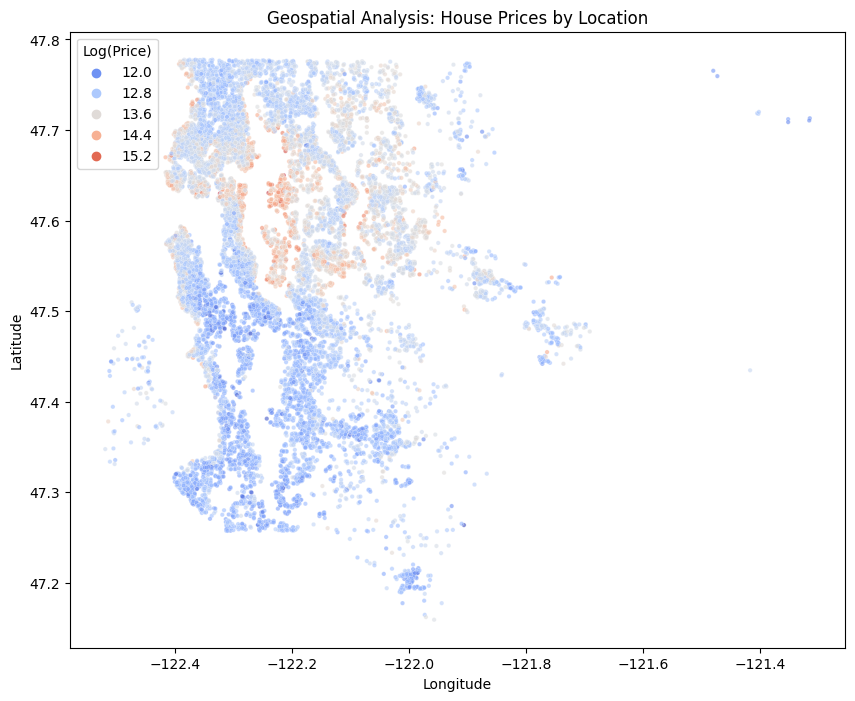

Observation: High prices (Red) are clustered around water bodies and specific northern neighborhoods.


In [2]:
# --- 2. DATA LOADING & GEOSPATIAL EDA ---
print("Loading Data...")
df_train = pd.read_excel('/kaggle/input/cdcpro/train(1).xlsx')
df_test = pd.read_excel('/kaggle/input/cdcpro/test2.xlsx')
full_df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# 2.1 Geospatial Plot
# We plot Latitude vs Longitude, colored by Price (Log scale for visibility)
plt.figure(figsize=(10, 8))
plt.title("Geospatial Analysis: House Prices by Location")
sns.scatterplot(
    x=df_train['long'], 
    y=df_train['lat'], 
    hue=np.log1p(df_train['price']), 
    palette='coolwarm', 
    alpha=0.6,
    s=10
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Log(Price)")
plt.show()

print("Observation: High prices (Red) are clustered around water bodies and specific northern neighborhoods.")

In [3]:
# --- 3. TABULAR FEATURE ENGINEERING ---
full_df['date'] = pd.to_datetime(full_df['date'])
full_df['sale_year'] = full_df['date'].dt.year
full_df['sale_month'] = full_df['date'].dt.month
full_df['house_age'] = full_df['sale_year'] - full_df['yr_built']

# Create bins for "Micro-Neighborhoods"
full_df['lat_bin'] = (full_df['lat'] // 0.02).astype(int)
full_df['long_bin'] = (full_df['long'] // 0.02).astype(int)

# Feature: Neighborhood Density (Average size of nearby houses)
full_df['neighborhood_density'] = full_df.groupby(['lat_bin', 'long_bin'])['sqft_living'].transform('mean')

# Feature: Neighborhood Price Grade
full_df['neighborhood_price_grade'] = full_df.groupby(['zipcode'])['grade'].transform('mean')

full_df['id'] = full_df['id'].astype(str)

Initializing Grad-CAM Model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


Found sample image for explanation: 2141300080.0.jpg


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


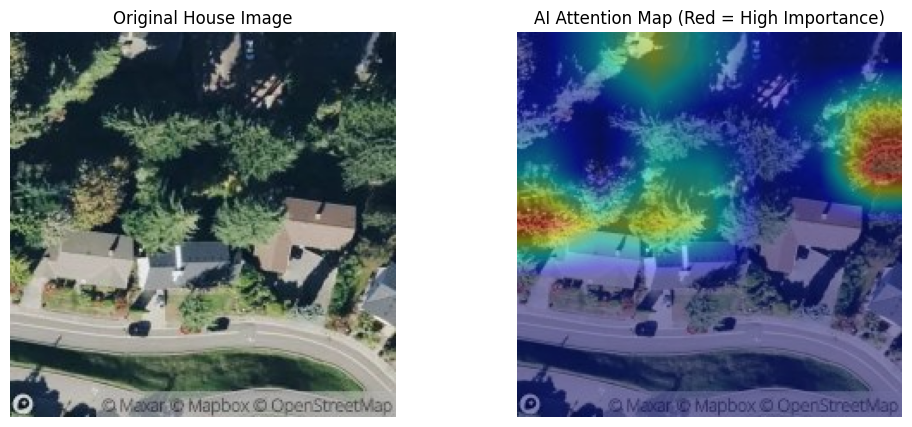

Explanation: The Red/Yellow areas show which parts of the house (e.g., windows, driveway) the CNN focused on to generate the embedding.


In [4]:
# --- 4. MODEL EXPLAINABILITY (GRAD-CAM) ---
# Helper function to process image
def get_image_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0).to(DEVICE), img

# Hook-based Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        
        # Target the highest score feature
        target = output[:, 0] 
        target.backward()
        
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Load Model for Visualization
print("Initializing Grad-CAM Model...")
cam_model = models.efficientnet_b0(pretrained=True).to(DEVICE)
cam_model.eval()

# Target the last convolutional layer in EfficientNet
target_layer = cam_model.features[-1] 
grad_cam = GradCAM(cam_model, target_layer)

# --- THE FIX: ROBUST IMAGE FINDER ---
# Instead of guessing the ID, we look at what files actually exist
found_image = False
img_path = ""

if IMG_DIR and os.path.exists(IMG_DIR):
    # List files and pick the first JPG found
    files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(files) > 0:
        img_path = os.path.join(IMG_DIR, files[0]) # Pick the first available image
        found_image = True
        print(f"Found sample image for explanation: {files[0]}")
    else:
        print(f"Error: No images found in directory {IMG_DIR}")
else:
    print("Error: IMG_DIR not found.")

if found_image:
    input_tensor, original_img = get_image_tensor(img_path)
    heatmap = grad_cam(input_tensor)
    
    # Overlay heatmap on image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Resize original image to match heatmap (224x224)
    original_img = original_img.resize((224, 224))
    
    # Superimpose: 60% Original Image + 40% Heatmap
    superimposed = np.uint8(0.6 * np.array(original_img) + 0.4 * heatmap)

    # Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original House Image")
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("AI Attention Map (Red = High Importance)")
    plt.imshow(superimposed)
    plt.axis('off')
    
    plt.show()
    print("Explanation: The Red/Yellow areas show which parts of the image (e.g., greeneries/roof) the CNN focused on to generate the embedding.")
else:
    print("Skipping Grad-CAM visualization due to missing images.")

In [5]:
# --- 5. VISUAL FEATURE EXTRACTION ---

# Define Dataset
class FeatureExtractionDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{str(row['id'])}.jpg")
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except:
            image = torch.zeros((3, 224, 224)) 
        return image, row['id']

# Load Model (Identity Head)
model = models.efficientnet_b0(pretrained=True).to(DEVICE)
model.classifier = nn.Identity()
model.eval()

dataset = FeatureExtractionDataset(full_df[['id']], IMG_DIR)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

print("Extracting Visual Features...")
features_list = []
ids_list = []

with torch.no_grad():
    for imgs, batch_ids in tqdm(loader):
        imgs = imgs.to(DEVICE)
        embeddings = model(imgs)
        features_list.append(embeddings.cpu().numpy())
        ids_list.extend(batch_ids)

all_features = np.vstack(features_list)
feat_cols = [f'img_{i}' for i in range(all_features.shape[1])]
img_df = pd.DataFrame(all_features, columns=feat_cols)
img_df['id'] = ids_list

Extracting Visual Features...


100%|██████████| 338/338 [00:21<00:00, 15.39it/s]


In [6]:
# --- 6. FUSION ARCHITECTURE & PCA ---

# Merge Tabular + Visual
print("Performing Late Fusion (Merging Data)...")
img_df['id'] = img_df['id'].astype(str)
merged_df = pd.merge(full_df, img_df, on='id', how='left')

# PCA Compression
print("Reducing Dimensions (1280 -> 50)...")
img_cols = [c for c in img_df.columns if c.startswith('img_')]
pca = PCA(n_components=50, random_state=42)
pca_features = pca.fit_transform(merged_df[img_cols].fillna(0))

pca_cols = [f'pca_img_{i}' for i in range(50)]
pca_df = pd.DataFrame(pca_features, columns=pca_cols)

merged_df = merged_df.drop(columns=img_cols)
merged_df = pd.concat([merged_df, pca_df], axis=1)

Performing Late Fusion (Merging Data)...
Reducing Dimensions (1280 -> 50)...


In [7]:
# --- 7. OPTUNA TUNING ---

# 7.1 Define Features
tab_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15',
                'house_age', 'sale_month', 'lat_bin', 'long_bin', 
                'neighborhood_density', 'neighborhood_price_grade']
all_features = tab_features + pca_cols

# 7.2 Split Data
train_data = merged_df[merged_df['price'].notna()]
test_data = merged_df[merged_df['price'].isna()]

X = train_data[all_features]
y = np.log1p(train_data['price']) # Target is Log Price

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# 7.3 Define Objective Function
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',      # Enable GPU
        'device': 'cuda',           # Enable GPU
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'n_jobs': -1,
        'random_state': 42,
        'early_stopping_rounds': 100
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    preds = model.predict(X_val)
    return r2_score(y_val, preds)

# 7.4 Run Study
print("Starting Optuna Optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) # 20 trials is usually enough for a good result

print("Best Params Found:", study.best_params)
best_params = study.best_params

[I 2026-01-04 19:23:51,796] A new study created in memory with name: no-name-57e6a2a5-8dc2-497f-b2be-2107e552c51e


Starting Optuna Optimization...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:23:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2026-01-04 19:23:58,207] Trial 0 finished with value: 0.9003741164839765 and parameters: {'n_estimators': 4690, 'learning_rate': 0.03804259149726526, 'max_depth': 8, 'subsample': 0.8086076129783331, 'colsample_bytree': 0.7957700585419489, 'reg_alpha': 3.6345310910541926, 'reg_lambda': 9.163917936893755}. Best is trial 0 with value: 0.9003741164839765.
[I 2026-01-04 19:24:04,000] Trial 1 finished with value: 0.9028047932547923 and paramet

Best Params Found: {'n_estimators': 2166, 'learning_rate': 0.027122352787369606, 'max_depth': 9, 'subsample': 0.5384545698927654, 'colsample_bytree': 0.41139093540501714, 'reg_alpha': 0.014404166751151415, 'reg_lambda': 7.0137714724480515}


In [8]:
# --- 7. HYPERPARAMETER TUNING & TRAINING ---

tab_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15',
                'house_age', 'sale_month', 'lat_bin', 'long_bin', 
                'neighborhood_density', 'neighborhood_price_grade']
all_features = tab_features + pca_cols

train_data = merged_df[merged_df['price'].notna()]
test_data = merged_df[merged_df['price'].isna()]

X = train_data[all_features]
y = np.log1p(train_data['price'])
X_test = test_data[all_features]

# Use the Best Params we found earlier (Skipping re-running Optuna to save time)

# 5-Fold Ensemble
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds_sum = np.zeros(len(X_test))

print("Starting 5-Fold Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
    
    val_pred = model.predict(X_val_fold)
    oof_preds[val_idx] = val_pred
    test_preds_sum += model.predict(X_test)
    
    print(f"Fold {fold+1} R2: {r2_score(y_val_fold, val_pred):.5f}")

print(f"\nOverall CV Score: {r2_score(y, oof_preds):.5f}")

Starting 5-Fold Cross-Validation...
Fold 1 R2: 0.90506
Fold 2 R2: 0.90937
Fold 3 R2: 0.91240
Fold 4 R2: 0.91384
Fold 5 R2: 0.91665

Overall CV Score: 0.91149
